# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Oriol Barbany"
student2 = "Vincent Cabrini"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io
import keract

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

In [3]:
# Get reproducible results
np.random.seed(123)

from tensorflow import set_random_seed
set_random_seed(123)

### Plotting

In [4]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j])%10, color='green', 
                                                       verticalalignment='top',
                                                       horizontalalignment='left',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k])%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

In [5]:
from keras.datasets import mnist, fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

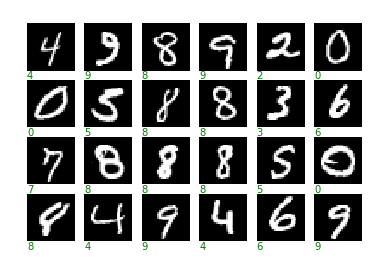

In [6]:
plot_some_samples(x_train, y_train)

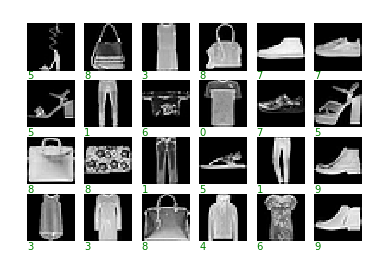

In [7]:
plot_some_samples(x_fashion_train, y_fashion_train)

The green digits correspond to the labels. In the case of the MNIST dataset, the labels correspond to the transcription of the handwritten digit, and in the case of the Fashion MNIST dataset, they correspond to the following clothes:


|Label	| Description  |
| ----- | ------------ |
|0	    | T-shirt/top  |
|1	    | Trouser      |
|2	    | Pullover     |
|3	    | Dress        |
|4	    | Coat         |
|5	    | Sandal       |
|6	    | Shirt        |
|7	    | Sneaker      |
|8	    | Bag          |
|9	    |Ankle boot    |

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [8]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [9]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

Check that we can indeed use the same model for MNIST and Fashion MNIST database

In [10]:
assert y_train.shape[1] == y_fashion_train.shape[1]

In [11]:
assert x_train.shape[1] == x_fashion_train.shape[1]

Create function to fit the perceptron

In [12]:
def fitPerceptron(x_train, y_train, x_test, y_test, optimizer='SGD', epochs=10,
                       loss='categorical_crossentropy', metrics=['accuracy'], verbose=0):
    # Use the softmax activation for the output layer.
    model = Sequential()
    model.add(Dense(y_train.shape[1], input_shape=(x_train.shape[1],), activation='softmax'))

    # Use the categorical_crossentropy loss.
    # Add the accuracy metric to the metrics.
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    
    # Choose a minibatch size of 128.
    history = model.fit(x_train, y_train, batch_size=128, epochs=epochs, 
                        validation_data=(x_test, y_test), verbose=verbose)
    
    # Plot the output of the fitting procedure using the function plot_history defined above.
    plot_history(history, 'loss')
    
    yhat_test = model.predict(x_test)
    
    error_indices = np.where(np.argmax(y_test, axis=1) != np.argmax(yhat_test, axis=1))[0]
    
    plot_some_samples(x_test, y_test, yhat_test, error_indices)
    
    print('Test error of prediction is {:.2f}%'.format((len(error_indices) / y_test.shape[0]) * 100))

Test error of prediction is 7.68%


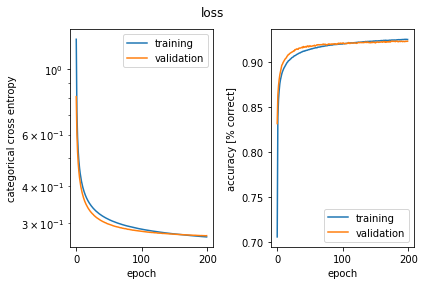

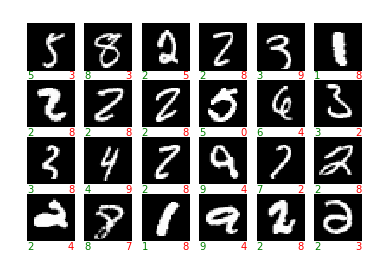

In [13]:
# Choose stochastic gradient descent for the optimizer (Default option in fitPeceptron)
# Fit for as many epochs as needed to see no further decrease in the validation loss.
fitPerceptron(x_train, y_train, x_test, y_test, epochs=200)

Note that the previous image correspond to some of the misclassified images. The green digit at the bottom of the image correspond to the ground truth, i.e. which number is really represented in the image, whilst the red digit correspond to the prediction of the Perceptron model.

Test error of prediction is 15.56%


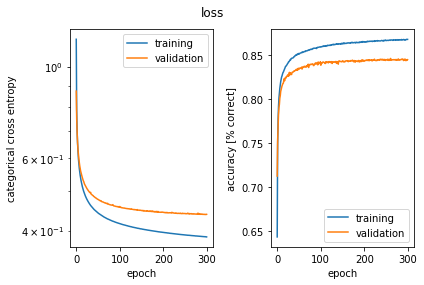

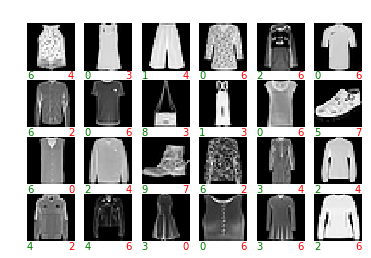

In [14]:
# Repeat procedure for fashion MNIST dataset
fitPerceptron(x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, epochs=300)

In this case, red and green numbers below the pictures also correspond to ground truth and prediction respectively. Note that this time, conversion from label to object is not trivial so we attach the table with the correspondance below.

|Label	| Description  |
| ----- | ------------ |
|0	    | T-shirt/top  |
|1	    | Trouser      |
|2	    | Pullover     |
|3	    | Dress        |
|4	    | Coat         |
|5	    | Sandal       |
|6	    | Shirt        |
|7	    | Sneaker      |
|8	    | Bag          |
|9	    |Ankle boot    |

Also note that, as expected, the missclassified items are usually from a same class of clothes, e.g. shoes are missclassified as other type of shoes (as they share some structure) and not as other clothes such as a Dress.

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

Let's now create a function of a model with one hidden layer

In [15]:
def create_model(hidden_units):
    model = Sequential()
    model.add(Dense(hidden_units, input_shape=(x_train.shape[1],), activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    return model

In [16]:
def train_model(model, optimizer='SGD', epochs = 50, batch_size = 128, verbose = 0,
                fashion = False, callbacks=None):
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    if fashion:
        history = model.fit(x_fashion_train, y_fashion_train, batch_size=batch_size, epochs=epochs,
                        validation_data=(x_fashion_test, y_fashion_test),
                            verbose=verbose, callbacks=callbacks)    
    else:
        history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                        validation_data=(x_test, y_test), verbose=verbose, callbacks=callbacks)
    return history

In [17]:
# Creae model with one hidden layer with 128 units and the 'relu' activation (default)
model = create_model(128)
# Use the summary method to display your model in a compact way.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Define the different learning rates we want to compare

In [18]:
lrs = [0.001, 0.01, 0.05, 0.1, 0.5]

In [19]:
# Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD)
history_sgd = []
for lr in lrs:
    model = create_model(128)
    optim = keras.optimizers.SGD(lr=lr)
    history_sgd.append(train_model(model, optimizer=optim, epochs=50))
    print('Done with model with Learning Rate', lr, 'for SGD optimizer')

Done with model with Learning Rate 0.001 for SGD optimizer
Done with model with Learning Rate 0.01 for SGD optimizer
Done with model with Learning Rate 0.05 for SGD optimizer
Done with model with Learning Rate 0.1 for SGD optimizer
Done with model with Learning Rate 0.5 for SGD optimizer


Let's now do the same thing with Adam optimizer

In [20]:
# Replace the stochastic gradient descent optimizer with the Adam optimizer
history_adam = []
for lr in lrs:
    model = create_model(128)
    optim = keras.optimizers.Adam(lr=lr)
    history_adam.append(train_model(model, optimizer=optim, epochs=50))
    print('Done with model with Learning Rate', lr, 'for Adam optimizer')

Done with model with Learning Rate 0.001 for Adam optimizer
Done with model with Learning Rate 0.01 for Adam optimizer
Done with model with Learning Rate 0.05 for Adam optimizer
Done with model with Learning Rate 0.1 for Adam optimizer
Done with model with Learning Rate 0.5 for Adam optimizer


In [21]:
def comparison_plot(history_sgd, history_adam, lrs, label1, label2, title):
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,9))
    fig.suptitle(title, fontsize=18)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel('epochs')
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel('epochs')
    
    color_sgd = iter(plt.cm.winter(np.linspace(0,1,len(history_sgd))))
    color_adam = iter(plt.cm.autumn(np.linspace(0,1,len(history_sgd))))
    
    for sgd, adam, lr in zip(history_sgd, history_adam, lrs):
        c_sgd = next(color_sgd)
        ax1.plot(sgd.history['loss'], label=label1 + ' with LR={:.3f}'.format(lr), c=c_sgd)
        ax1.plot(sgd.history['val_loss'], linestyle='--', c=c_sgd)
        ax2.plot(sgd.history['acc'], label=label1 + ' with LR={:.3f}'.format(lr), c=c_sgd)
        ax2.plot(sgd.history['val_acc'], linestyle='--', c=c_sgd)

        c_adam = next(color_adam)
        ax1.plot(adam.history['loss'], label=label2 + ' with LR={:.3f}'.format(lr), c=c_adam)
        ax1.plot(adam.history['val_loss'], linestyle='--', c=c_adam)
        ax2.plot(adam.history['acc'], label=label2 + ' with LR={:.3f}'.format(lr), c=c_adam)
        ax2.plot(adam.history['val_acc'], linestyle='--', c=c_adam)
        
        finalize_standardplot(fig, ax1, ax2)

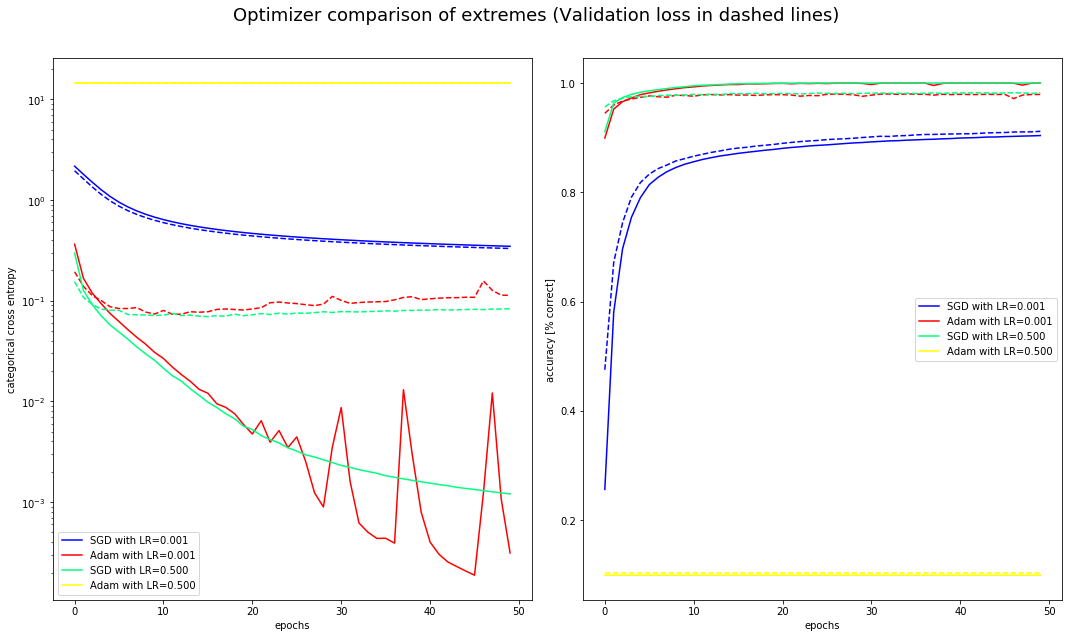

In [22]:
comparison_plot([history_sgd[0], history_sgd[-1]], [history_adam[0], history_adam[-1]],
                [lrs[0], lrs[-1]], 'SGD', 'Adam',
                'Optimizer comparison of extremes (Validation loss in dashed lines)')

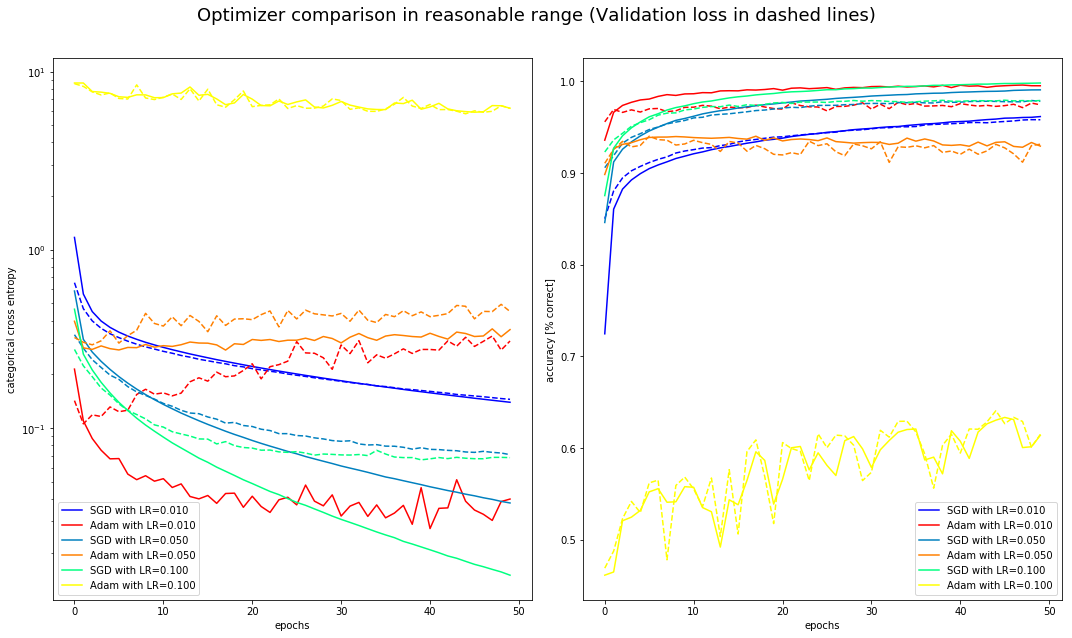

In [23]:
# Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) 
# together with the learning curves of Adam in the same figure
comparison_plot(history_sgd[1:-1], history_adam[1:-1], lrs[1:-1], 'SGD', 'Adam',
                'Optimizer comparison in reasonable range (Validation loss in dashed lines)')

With LR = 0.001 ADAM increases validation error at epochs [ 6  7 10 13 15 16 17 20 21 22 23 28 29 32 33 34 35 36 37 38 40 41 42 43
 44 46]
With LR = 0.01 ADAM increases validation error at epochs [ 2  4  6  7  8 10 12 13 14 16 18 19 20 22 23 24 25 30 32 34 36 37 39 42
 44 46 47 49]
With LR = 0.05 ADAM increases validation error at epochs [ 3  4  6  7  8 11 13 16 18 19 21 22 24 26 30 32 35 37 39 41 42 43 46 48]
With LR = 0.1 ADAM increases validation error at epochs [ 4  7 10 11 13 15 18 19 21 22 23 25 27 28 29 32 35 36 37 40 42 45 47 48]
With LR = 0.5 ADAM increases validation error at epochs [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]


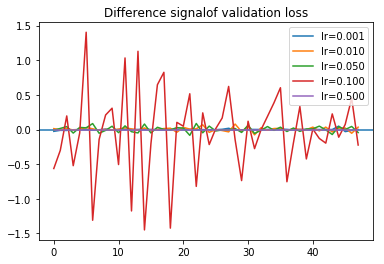

In [24]:
# Overfitting in ADAM (greater validation loss in next iteration)
plt.title('Difference signalof validation loss')
plt.axhline(y=0)

for hist, lr in zip(history_adam, lrs):
    aux = np.asarray(hist.history['val_loss'])
    print('With LR =', lr, 'ADAM increases validation error at epochs', np.where(aux[1:] - aux[:-1] >= 0)[0] + 1)
    plt.plot(aux[2:] - aux[1:-1], label='lr={:.3f}'.format(lr))

plt.legend();

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) With a very large learning rate for SGD, we overfit at the early epochs, namely at first or second. Note that in the first plot (comparison of extremes) the green line corresponding to the training error quickly decreases at each step, but the dashed line with the same color, corresponding to the validation loss, it's almost flat and even slightly increasing.

B) When learning rate is very small for SGD, e.g. 0.001, model learns very slowly. This is translated into almost flat curves after 10 epochs for both categorical cross entropy and accuracy (very slightly decreasing and increasing respectively). Note nevertheless that with this very small learning rate, the training error is very close to the validation error.

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: We can say that Adam starts to overfit after around 10 epochs (see code cell above and note that after 10, all epochs with non-decreasing validation loss are almost consecutive - except with a very large learning rate, where we don't see any improvement).

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: Regarding the loss curves, we can observe that after some epochs, training loss keeps decreasing, while validation loss starts to increase. This is the sign of overfitting, meaning that we started to fit the noise of the training data, which is not desirable as we want our model work for new data as well. 

Considering accuracy, note that after a certain number of epochs, train accuracy is still increasing while validation accuracy remains almost flat (decreases much slower than loss). This can be justified because accuracy can remain flat whilst loss gets worse as long as the predictions don't change after the rounding, e.g. in a binary classification problem with labels $\{\pm 1\}$ we can predict 0.1 instead of 1 and hence we would have a larger loss, but the same accuracy as long as the prediction remains positive (if we round with the sign function).

----

We can observe that Adam achieves much faster convergence (overfitting after only ~10 epochs) than SGD and also requires smaller learning rates than SGD or it doesn't learn (see saturated curves for learning rates 0.1 and 0.5). With SGD, we have smoother curves and even if it's slower, we converge to better solutions. The setup with SGD and a learning rate of 0.05 seems to outperform all the other configurations of optimizers (even if lowest validation loss is with SGD and learning rate 0.1, the curve is flat in this case and hence the model is likely to be overfitted). 


Look for the learning rate of the ones tested that achieves minimum validation loss in the previous trials for ADAM optimize:

In [25]:
minimum = 1e6
for idx, hist in enumerate(history_adam):
    current_min = min(hist.history['val_loss'])
    if minimum > current_min:
        minimum = current_min
        index = idx
opt_lr = lrs[index]
print('According to previous examples, best learning rate for ADAM is', opt_lr)

According to previous examples, best learning rate for ADAM is 0.001


In [26]:
# Run the network (using the Adam optimizer - with optimal LR) on the Fashion-MNIST dataset
model = create_model(128)
optim = keras.optimizers.Adam(lr=opt_lr, decay=1e-6)
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_fashion_train, y_fashion_train, batch_size=128, callbacks=[es], epochs=200,
                        validation_data=(x_fashion_test, y_fashion_test), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 2s 35us/step - loss: 0.5531 - acc: 0.8121 - val_loss: 0.4765 - val_acc: 0.8347
Epoch 2/200
60000/60000 [==============================] - 2s 30us/step - loss: 0.4069 - acc: 0.8566 - val_loss: 0.4227 - val_acc: 0.8530
Epoch 3/200
60000/60000 [==============================] - 2s 30us/step - loss: 0.3629 - acc: 0.8714 - val_loss: 0.3990 - val_acc: 0.8536
Epoch 4/200
60000/60000 [==============================] - 2s 32us/step - loss: 0.3406 - acc: 0.8780 - val_loss: 0.3981 - val_acc: 0.8612
Epoch 5/200
60000/60000 [==============================] - 2s 32us/step - loss: 0.3207 - acc: 0.8847 - val_loss: 0.3579 - val_acc: 0.8742
Epoch 6/200
60000/60000 [==============================] - 2s 32us/step - loss: 0.3060 - acc: 0.8894 - val_loss: 0.3624 - val_acc: 0.8701
Epoch 7/200
60000/60000 [==============================] - 2s 33us/step - loss: 0.2930 - acc: 0.8936 - val_loss: 0.3613 - 

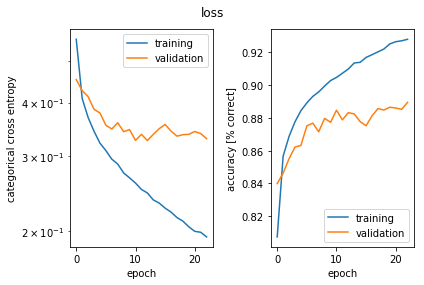

In [27]:
# Plot the learning curves
plot_history(history, 'loss')

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

In [28]:
# Fit 5 models with different hidden layer sizes (between 10 and 1000 hidden neurons)
hidden_sizes = [10, 50, 100, 500, 1000]

In [29]:
# Define Early stopping callback to train the network during a meaningful number of epochs
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

In [30]:
def test_hidden_size(fashion=False):
    history_hidden_sizes = []
    for hidden_units in hidden_sizes:
        model = create_model(hidden_units)
        optim = keras.optimizers.Adam(lr=opt_lr, decay=1e-6)
        history_hidden_sizes.append(train_model(model, optimizer=optim, callbacks=[es], epochs=200))
        print('Model with', hidden_units, 'hidden units trained!')
    
    minimum = []
    for h in history_hidden_sizes:
        minimum.append(min(h.history['val_loss']))

    maximum = []
    for h in history_hidden_sizes:
        maximum.append(max(h.history['val_acc']))

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))
    fig.suptitle('Comparison of hidden sizes in ' + 'Fashion '*fashion + 'MNIST database', fontsize=18)

    ax1.plot(hidden_sizes, minimum, marker=".")
    ax1.set_xlabel('Hidden size')
    ax1.set_ylabel('Minimum validation loss')
    ax1.set_yscale('log')
    ax1.set_xscale('log')

    ax2.plot(hidden_sizes, maximum, marker=".")
    ax2.set_xlabel('Hidden size')
    ax2.set_ylabel('Maximum accuracy')
    ax2.set_yscale('log')
    ax2.set_xscale('log')

    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

Model with 10 hidden units trained!
Model with 50 hidden units trained!
Model with 100 hidden units trained!
Model with 500 hidden units trained!
Model with 1000 hidden units trained!


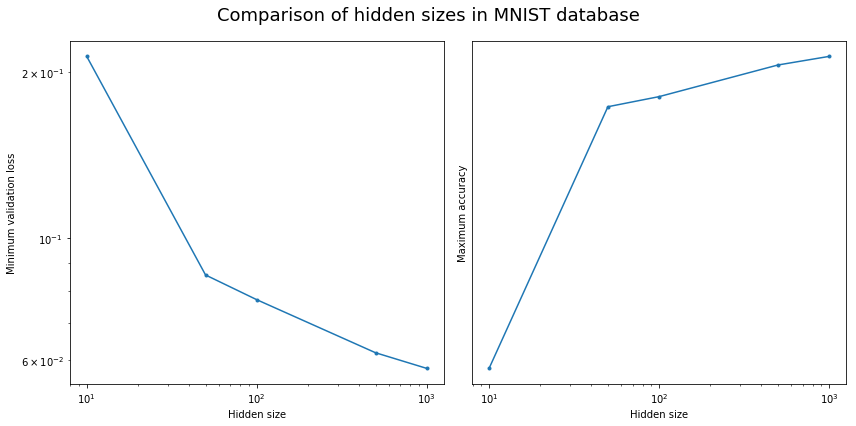

In [31]:
# Plot the best validation loss and accuracy versus the number of hidden neurons for MNIST
test_hidden_size()

**Answer to question 2:** The trend is indeed in accordance to the general approximation theorem, i.e. as the number of hidden neurons increases, the loss decreases and the accuracy increases. Note that the previous plot is in logarithmic scale for both axis because the improvement is very large when changing from 10 to 50 hidden neurons and otherwise the change in the other cases would be hidden.

Model with 10 hidden units trained!
Model with 50 hidden units trained!
Model with 100 hidden units trained!
Model with 500 hidden units trained!
Model with 1000 hidden units trained!


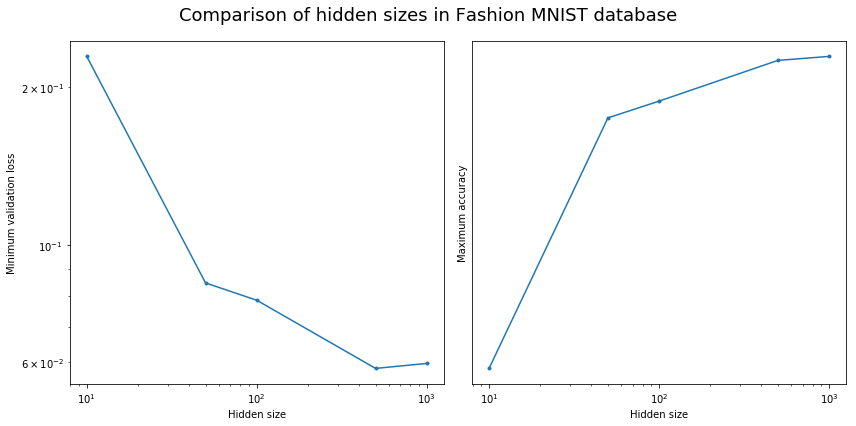

In [32]:
# Plot the best validation loss and accuracy versus the number of hidden neurons for Fashion MNIST
test_hidden_size(fashion=True)

**Answer to question 3 (2 for Fashion dataset):** In this case, the trend is mostly in accordance to the general approximation theorem, i.e. the increment in the number of hidden neurons always improves the validation accuracy. Nevertheless for the validation loss, we can see that some models outperform others with more number of hidden units (see 500 vs 1000 hidden units, the last two points) because a feedforward network with a single layer is sufficient to represent any function, but the layer may be infeasibly large and may fail to learn and generalize correctly [Goodfellow et al. 2016].

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

Define naive and tuned model

In [33]:
# Add two hidden layers with 50 hidden neurons each to the previous 1-hidden layer model
hidden_units = [128, 50, 50]

Note that we use 128 hidden units in the first layer as in exercise 3, which at least for one hidden layer is more than reasonable. This is because as seen in the comparison of the number of hidden units for the MNIST dataset, we barely improve adding more than 100 units, but we do improve a lot by going from 10 to 100.

In [34]:
def get_naive_model():
    naive_model = Sequential()
    naive_model.add(Dense(hidden_units[0], input_shape=(x_train.shape[1],), activation='relu'))
    naive_model.add(Dense(hidden_units[1], activation='relu'))
    naive_model.add(Dense(hidden_units[2], activation='relu'))
    naive_model.add(Dense(y_train.shape[1], activation='softmax'))
    return naive_model

In [35]:
def get_tuned_model(l2_reg, batch_norm, dropout):
    tuned_model = Sequential()
    
    tuned_model.add(Dense(hidden_units[0], input_shape=(x_train.shape[1],), activation='relu',
              kernel_regularizer=keras.regularizers.l2(l2_reg)))
    
    if batch_norm:
        tuned_model.add(keras.layers.BatchNormalization())
    
    tuned_model.add(Dropout(dropout))
    
    tuned_model.add(Dense(hidden_units[1], activation='relu',
              kernel_regularizer=keras.regularizers.l2(l2_reg)))
    
    if batch_norm:
        tuned_model.add(keras.layers.BatchNormalization())
    
    tuned_model.add(Dropout(dropout))
    
    tuned_model.add(Dense(hidden_units[2], activation='relu',
              kernel_regularizer=keras.regularizers.l2(l2_reg)))
    
    if batch_norm:
        tuned_model.add(keras.layers.BatchNormalization())
    
    tuned_model.add(Dropout(dropout))
    
    tuned_model.add(Dense(y_train.shape[1], activation='softmax'))
    return tuned_model

In [36]:
optim = keras.optimizers.Adam(lr=0.0005, decay=1e-4)
history_naive = train_model(get_naive_model(), optimizer=optim, epochs=200, fashion=True, verbose=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 6s 104us/step - loss: 0.6219 - acc: 0.7904 - val_loss: 0.4627 - val_acc: 0.8380
Epoch 2/200
60000/60000 [==============================] - 3s 55us/step - loss: 0.4065 - acc: 0.8583 - val_loss: 0.4366 - val_acc: 0.8450
Epoch 3/200
60000/60000 [==============================] - 3s 56us/step - loss: 0.3696 - acc: 0.8684 - val_loss: 0.3914 - val_acc: 0.8629
Epoch 4/200
60000/60000 [==============================] - 3s 51us/step - loss: 0.3436 - acc: 0.8770 - val_loss: 0.3751 - val_acc: 0.8697
Epoch 5/200
60000/60000 [==============================] - 3s 54us/step - loss: 0.3260 - acc: 0.8824 - val_loss: 0.3649 - val_acc: 0.8679
Epoch 6/200
60000/60000 [==============================] - 3s 45us/step - loss: 0.3098 - acc: 0.8878 - val_loss: 0.3564 - val_acc: 0.8711
Epoch 7/200
60000/60000 [==============================] - 3s 44us/step - loss: 0.2972 - acc: 0.8907 - val_loss: 0.3496 -

Epoch 118/200
60000/60000 [==============================] - 3s 46us/step - loss: 0.0535 - acc: 0.9833 - val_loss: 0.5150 - val_acc: 0.8876
Epoch 119/200
60000/60000 [==============================] - 3s 48us/step - loss: 0.0528 - acc: 0.9840 - val_loss: 0.5246 - val_acc: 0.8876
Epoch 120/200
60000/60000 [==============================] - 3s 53us/step - loss: 0.0513 - acc: 0.9848 - val_loss: 0.5206 - val_acc: 0.8853
Epoch 121/200
60000/60000 [==============================] - 3s 50us/step - loss: 0.0517 - acc: 0.9846 - val_loss: 0.5250 - val_acc: 0.8861
Epoch 122/200
60000/60000 [==============================] - 3s 49us/step - loss: 0.0502 - acc: 0.9853 - val_loss: 0.5265 - val_acc: 0.8875
Epoch 123/200
60000/60000 [==============================] - 3s 45us/step - loss: 0.0507 - acc: 0.9844 - val_loss: 0.5260 - val_acc: 0.8876
Epoch 124/200
60000/60000 [==============================] - 3s 48us/step - loss: 0.0509 - acc: 0.9842 - val_loss: 0.5345 - val_acc: 0.8874
Epoch 125/200
60000/

In [37]:
# Look for best parameters. Put early stopping callback to avoid running for a very long time
opt_param = {'l2_reg': 0, 'batch_norm': False, 'dropout': 0}
global_max = 0

for l2_reg in [0, 0.001, 0.01]:
    for batch_norm in [False, True]:
        for dropout in [0, 0.15, 0.25, 0.5]:
            optim = keras.optimizers.Adam(lr=0.001, decay=1e-4)
            tmp_history_tuned = train_model(get_tuned_model(l2_reg, batch_norm, dropout), optimizer=optim, 
                                            epochs=200, fashion=True, verbose=False, callbacks=[es])
            current_max = max(tmp_history_tuned.history['val_acc'])
            print('Max for the configuration:', l2_reg, batch_norm, dropout, 'is', current_max)
            if current_max > global_max:
                global_max = current_max
                history_tuned = tmp_history_tuned
                opt_param['l2_reg'] = l2_reg
                opt_param['batch_norm'] = batch_norm
                opt_param['dropout'] = dropout

Max for the configuration: 0 False 0 is 0.892
Max for the configuration: 0 False 0.15 is 0.8948
Max for the configuration: 0 False 0.25 is 0.8918
Max for the configuration: 0 False 0.5 is 0.8717
Max for the configuration: 0 True 0 is 0.89
Max for the configuration: 0 True 0.15 is 0.8901
Max for the configuration: 0 True 0.25 is 0.8912
Max for the configuration: 0 True 0.5 is 0.8839
Max for the configuration: 0.001 False 0 is 0.8895
Max for the configuration: 0.001 False 0.15 is 0.8904
Max for the configuration: 0.001 False 0.25 is 0.8916
Max for the configuration: 0.001 False 0.5 is 0.8684
Max for the configuration: 0.001 True 0 is 0.8819
Max for the configuration: 0.001 True 0.15 is 0.8757
Max for the configuration: 0.001 True 0.25 is 0.8784
Max for the configuration: 0.001 True 0.5 is 0.8749
Max for the configuration: 0.01 False 0 is 0.8648
Max for the configuration: 0.01 False 0.15 is 0.8677
Max for the configuration: 0.01 False 0.25 is 0.8681
Max for the configuration: 0.01 False 0

In [38]:
# Pick best model according to previous hypertuning
optim = keras.optimizers.Adam(lr=0.0005, decay=1e-4)
history_tuned = train_model(get_tuned_model(opt_param['l2_reg'], opt_param['batch_norm'], opt_param['dropout']),
                      optimizer=optim, verbose=True, fashion=True, epochs=200)

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 6s 106us/step - loss: 0.8574 - acc: 0.7035 - val_loss: 0.4969 - val_acc: 0.8282
Epoch 2/200
60000/60000 [==============================] - 3s 56us/step - loss: 0.5139 - acc: 0.8214 - val_loss: 0.4357 - val_acc: 0.8460
Epoch 3/200
60000/60000 [==============================] - 3s 55us/step - loss: 0.4458 - acc: 0.8422 - val_loss: 0.3996 - val_acc: 0.8556
Epoch 4/200
60000/60000 [==============================] - 3s 56us/step - loss: 0.4124 - acc: 0.8557 - val_loss: 0.3906 - val_acc: 0.8595
Epoch 5/200
60000/60000 [==============================] - 3s 55us/step - loss: 0.3882 - acc: 0.8626 - val_loss: 0.3715 - val_acc: 0.8678
Epoch 6/200
60000/60000 [==============================] - 3s 56us/step - loss: 0.3686 - acc: 0.8690 - val_loss: 0.3673 - val_acc: 0.8673
Epoch 7/200
60000/60000 [==============================] - 3s 56us/step - loss: 0.3553 - acc: 0.8731 - val_loss: 0.3572 -

Epoch 118/200
60000/60000 [==============================] - 4s 61us/step - loss: 0.1322 - acc: 0.9516 - val_loss: 0.3608 - val_acc: 0.8937
Epoch 119/200
60000/60000 [==============================] - 4s 65us/step - loss: 0.1328 - acc: 0.9520 - val_loss: 0.3613 - val_acc: 0.8955
Epoch 120/200
60000/60000 [==============================] - 4s 65us/step - loss: 0.1317 - acc: 0.9524 - val_loss: 0.3638 - val_acc: 0.8969
Epoch 121/200
60000/60000 [==============================] - 4s 66us/step - loss: 0.1309 - acc: 0.9526 - val_loss: 0.3636 - val_acc: 0.8934
Epoch 122/200
60000/60000 [==============================] - 3s 52us/step - loss: 0.1315 - acc: 0.9520 - val_loss: 0.3600 - val_acc: 0.8972
Epoch 123/200
60000/60000 [==============================] - 3s 51us/step - loss: 0.1296 - acc: 0.9524 - val_loss: 0.3623 - val_acc: 0.8957
Epoch 124/200
60000/60000 [==============================] - 3s 50us/step - loss: 0.1283 - acc: 0.9528 - val_loss: 0.3679 - val_acc: 0.8962
Epoch 125/200
60000/

In [39]:
def compare_two_models(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    
    finalize_standardplot(fig, ax1, ax2)
    return fig

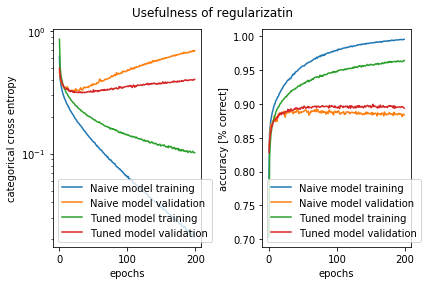

In [40]:
compare_two_models(history_naive, history_tuned, 'Naive model', 'Tuned model',
                  'Usefulness of regularizatin');

In [41]:
print(max(history_naive.history['val_acc']))
print(max(history_tuned.history['val_acc']))

0.8917
0.8993


**Answer to question 2 (comments)**: As we can see, with the tuned model we achieve slightly better performance than in exercise 3.6, where the best accuracy achieved with early stopping (which lasts for only 24 epochs) is 0.8916. Also note that we don't have a significant improvement by adding two more hidden layers and training for 200 epochs as in the naive model and the tuning in this naive model is also not translated into major gains in the obtained accuracy.

Maximum validation accuracy is 0.9804


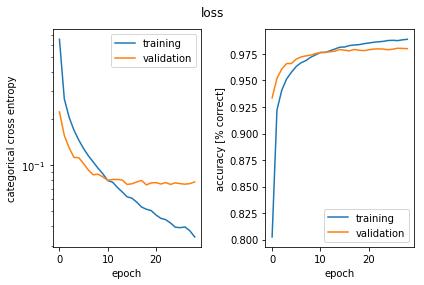

In [42]:
optim = keras.optimizers.Adam(lr=0.0005, decay=1e-4)
history = train_model(get_tuned_model(opt_param['l2_reg'], opt_param['batch_norm'], opt_param['dropout']),
                      optimizer=optim, epochs=200, callbacks=[es])
plot_history(history, 'loss')
print('Maximum validation accuracy is', max(history.history['val_acc']))

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

### MNIST:

In [43]:
batch_size = 16
num_classes = 10
epochs = 12
input_shape = (28, 28, 1)

In [44]:
def load_data(dataset = 'mnist', samples = None):
    # input image dimensions
    img_rows, img_cols = 28, 28
    
    if (dataset == 'mnist'):
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

    #reshape data to fit model
    x_train = x_train.reshape(60000,28,28,1)
    x_test = x_test.reshape(10000,28,28,1)
    
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    return x_train, y_train, x_test, y_test

In [45]:
#loading mnist
x_train, y_train, x_test, y_test = load_data()

In [46]:
def CNN_fit(model, loss='categorical_crossentropy', optimizer='SGD', 
            verbose = 1, checkpoint = None):
    model.compile(loss=loss,
                optimizer=optimizer,
                metrics=['accuracy'])
    
    if checkpoint != None:
        checkpoint = ModelCheckpoint(monitor='val_acc', save_best_only=True,
                        filepath=os.path.join('', 'checkpoint' + '.h5'))
        history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=verbose,
              validation_data=(x_test, y_test),
              callbacks = [checkpoint])
    else:
        history = model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=verbose,
                  validation_data=(x_test, y_test))
    return history

def CNN_compare_plot(models, models_name = None, dataset = 'mnist', verbose = 1):
    histories = []
    best_model = {'id': -1,
              'value': np.Infinity
             }
    #fits the models
    for i, model in enumerate(models):
        h = CNN_fit(model, verbose = verbose, checkpoint = 'model' + str(i))
        histories.append(h)
        if best_model['value'] < np.max(h.history['val_acc']):
            best_model['value'] = np.max(h.history['val_acc'])
            best_model['id'] = i
    #plot the results   
    for i, h in enumerate(histories):
        
        if models_name == None:
            plt.plot(h.history['val_acc'], label = "acc model " + str(i+1))
        else:
            plt.plot(h.history['val_acc'], label = models_name[i])
        plt.legend(loc = 4)
    plt.ylabel('validation accuracy')
    plt.xlabel('epoch')
    plt.title('Validation accuracy of different CNNs')
    print('The best model is the model :' + str(best_model['id']) + ' with ' + str(best_model['value']))

The first model here is the one given on the example [mnist_cnn.py](https://github.com/keras-team/keras/tree/master/examples/mnist_cnn.py), we use here a smaller batch size because the gradient computation is much cheaper in each iteration and thus we go faster.

In [47]:
models = []

#model1 - model of keras mnist_cnn.py
model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(num_classes, activation='softmax'))
models.append(model1)

new_config = model1.get_config()

#model2 - doubled the filters on the second layer
config2 = copy.deepcopy(new_config)
config2['layers'][1]['config']['filters'] = 128
model2 = Sequential.from_config(config2['layers'])
models.append(model2)

#model3 - without maxpooling
config3 = copy.deepcopy(new_config)
config3['layers'].remove(config3['layers'][2]) #removing the pooling layer
model3 = Sequential.from_config(config3['layers'])
models.append(model3)

#model4 - Added a maxpooling layer
config4 = copy.deepcopy(new_config)
#copy the configuration of the pooling layer to create a new one by changing the name
pooling_config = copy.deepcopy(config4['layers'][2])
pooling_config['config']['name'] = pooling_config['config']['name'] + '_2'
#adding the pooling layer
config4['layers'] = config4['layers'][0:1] + [pooling_config] + config4['layers'][1:]
model4 = Sequential.from_config(config4['layers'])
models.append(model4)

#model5 - lowered dropout - best with 0.9883 val acc
config5 = copy.deepcopy(new_config)
config5['layers'][6]['config']['rate'] = 0.25
model5 = Sequential.from_config(config5['layers'])
models.append(model5)

models_name = ['naive', 'naive with 128 filters', 'no maxpooling', 'naive + maxpooling', 'lowered dropout']

The best model is the model :1 with 0.988


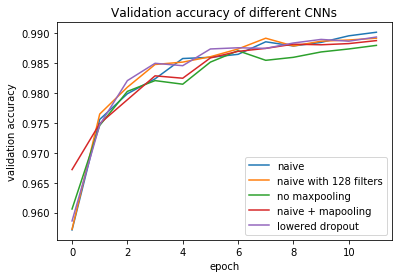

In [48]:
#MNIST dataset
CNN_compare_plot(models, models_name = models_name, verbose = 0)

The best model is the model :5 with 0.8875


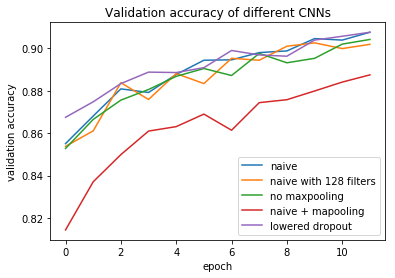

In [49]:
#fashion MNIST dataset
x_train, y_train, x_test, y_test = load_data(dataset = 'fashion')
CNN_compare_plot(models, models_name = models_name, verbose = 0)

The model 5 is the best and it seems that it is not overfitting after training for 12 epochs, so let's train it for 12 epochs more:

In [50]:
#training the model 5 for 12 more epochs
epochs = 12
h = CNN_fit(model5, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 285s 5ms/step - loss: 0.2227 - acc: 0.9173 - val_loss: 0.2546 - val_acc: 0.9086
Epoch 2/12
60000/60000 [==============================] - 274s 5ms/step - loss: 0.2168 - acc: 0.9201 - val_loss: 0.2444 - val_acc: 0.9107
Epoch 3/12
60000/60000 [==============================] - 263s 4ms/step - loss: 0.2053 - acc: 0.9235 - val_loss: 0.2515 - val_acc: 0.9128
Epoch 4/12
60000/60000 [==============================] - 246s 4ms/step - loss: 0.2002 - acc: 0.9251 - val_loss: 0.2486 - val_acc: 0.9104
Epoch 5/12
60000/60000 [==============================] - 258s 4ms/step - loss: 0.1950 - acc: 0.9272 - val_loss: 0.2402 - val_acc: 0.9135
Epoch 6/12
60000/60000 [==============================] - 256s 4ms/step - loss: 0.1877 - acc: 0.9301 - val_loss: 0.2376 - val_acc: 0.9147
Epoch 7/12
60000/60000 [==============================] - 249s 4ms/step - loss: 0.1818 - acc: 0.9328 - val_loss: 0.2372 - 

**Answer to question 3:** We observe that we have almost the same accuracy (98.8% vs 98.04%) with our best CNN and the best neural network respectively for the MNIST dataset because the MNIST problem is relatively easy so it can be solved by the best neural network given that the minor improvement introduced by the CNN supposes a higher computational cost and thus a slower training.
The performance differs more with the fashion MNIST dataset: our best deep neural network reached 89.93% accuracy whilst the best CNN had a validation accuracy of 92.05%, so in this case it is worth using a CNN given that the inductive bias of this architecture fits very well for images due to its equivariance and the improvement in the accuracy is statistically significant.

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behavior. For that, create histograms of the hidden activations for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

For this exercise we decided to use the fashion MNIST dataset since with the MNIST dataset the problem is already solved almost perfectly with a regular deep neural network. With a more complex problem the differences between  different models should be more significant.

# 1.

In [51]:
#fashion MNIST dataset
x_train, y_train, x_test, y_test = load_data(dataset = 'fashion')

In [52]:
#Example of the keras example mnist_cnn.py but ReLu is replaced with the
#sigmoid activation function
model1Sig = Sequential()
model1Sig.add(Conv2D(32, kernel_size=(3, 3),
                     activation='sigmoid',
                     input_shape=input_shape))
model1Sig.add(Conv2D(64, (3, 3), activation='sigmoid'))
model1Sig.add(MaxPooling2D(pool_size=(2, 2)))
model1Sig.add(Dropout(0.25))
model1Sig.add(Flatten())
model1Sig.add(Dense(128, activation='sigmoid'))
model1Sig.add(Dropout(0.25))
model1Sig.add(Dense(num_classes, activation='softmax'))

In [53]:
CNN_fit(model1Sig, checkpoint = 'CNN_Sig', verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 280s 5ms/step - loss: 2.3084 - acc: 0.1003 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 2/12
60000/60000 [==============================] - 279s 5ms/step - loss: 2.3027 - acc: 0.1033 - val_loss: 2.3021 - val_acc: 0.1000
Epoch 3/12
60000/60000 [==============================] - 279s 5ms/step - loss: 2.3017 - acc: 0.1061 - val_loss: 2.2994 - val_acc: 0.1000
Epoch 4/12
60000/60000 [==============================] - 279s 5ms/step - loss: 1.9878 - acc: 0.2613 - val_loss: 1.0448 - val_acc: 0.6503
Epoch 5/12
60000/60000 [==============================] - 278s 5ms/step - loss: 0.8249 - acc: 0.6968 - val_loss: 0.6787 - val_acc: 0.7492
Epoch 6/12
60000/60000 [==============================] - 278s 5ms/step - loss: 0.6663 - acc: 0.7479 - val_loss: 0.6132 - val_acc: 0.7653
Epoch 7/12
60000/60000 [==============================] - 282s 5ms/step - loss: 0.6140 - acc: 0.7681 - val_loss: 0.5802 - 

# 2.

In [55]:
#Same as last model but with BatchNormalization before all 
#fully connected and convolutional layer
model2Sig = Sequential()
model2Sig.add(keras.layers.BatchNormalization())
model2Sig.add(Conv2D(32, kernel_size=(3, 3),
                     activation='sigmoid',
                     input_shape=input_shape))
model2Sig.add(keras.layers.BatchNormalization())
model2Sig.add(Conv2D(64, (3, 3), activation='sigmoid'))
model2Sig.add(MaxPooling2D(pool_size=(2, 2)))
model2Sig.add(Dropout(0.25))
model2Sig.add(Flatten())
model2Sig.add(keras.layers.BatchNormalization())
model2Sig.add(Dense(128, activation='sigmoid'))
model2Sig.add(Dropout(0.5))
model2Sig.add(Dense(num_classes, activation='softmax'))

In [56]:
CNN_fit(model2Sig, checkpoint = 'CNN_Sig_Norm')

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 451s 8ms/step - loss: 0.7679 - acc: 0.7251 - val_loss: 0.4868 - val_acc: 0.8209
Epoch 2/12
60000/60000 [==============================] - 445s 7ms/step - loss: 0.5601 - acc: 0.8017 - val_loss: 0.4260 - val_acc: 0.8464
Epoch 3/12
60000/60000 [==============================] - 445s 7ms/step - loss: 0.4930 - acc: 0.8246 - val_loss: 0.3850 - val_acc: 0.8598
Epoch 4/12
60000/60000 [==============================] - 446s 7ms/step - loss: 0.4551 - acc: 0.8382 - val_loss: 0.3629 - val_acc: 0.8719
Epoch 5/12
60000/60000 [==============================] - 449s 7ms/step - loss: 0.4180 - acc: 0.8531 - val_loss: 0.3343 - val_acc: 0.8825
Epoch 6/12
60000/60000 [==============================] - 448s 7ms/step - loss: 0.3936 - acc: 0.8632 - val_loss: 0.3133 - val_acc: 0.8911
Epoch 7/12
60000/60000 [==============================] - 453s 8ms/step - loss: 0.3715 - acc: 0.8711 - val_loss: 0.3011 - 

# 3.

In [58]:
#reducing the number of epoch to get model when its still have the vanishing gradient
epochs = 2
modelTestSig = keras.models.clone_model(model1Sig) #this one should be defective
modelTestSigNorm = keras.models.clone_model(model2Sig)
CNN_fit(modelTestSig, verbose = 1)
CNN_fit(modelTestSigNorm, verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 195s 3ms/step - loss: 2.3086 - acc: 0.0998 - val_loss: 2.3026 - val_acc: 0.1821
Epoch 2/2
60000/60000 [==============================] - 198s 3ms/step - loss: 2.3028 - acc: 0.1004 - val_loss: 2.3024 - val_acc: 0.1000
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 288s 5ms/step - loss: 0.7657 - acc: 0.7327 - val_loss: 0.4873 - val_acc: 0.8209
Epoch 2/2
60000/60000 [==============================] - 293s 5ms/step - loss: 0.5534 - acc: 0.8053 - val_loss: 0.4169 - val_acc: 0.8485


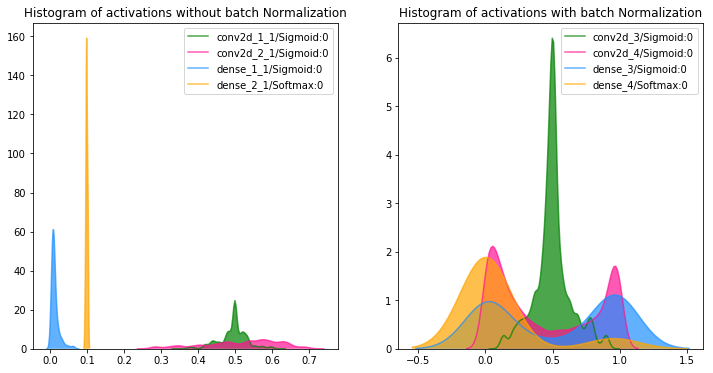

In [60]:
import seaborn as sns

activationsTestSig = keract.get_activations(modelTestSig, x_test[9192:9193])

colors = ['g', 'deeppink', 'dodgerblue', 'orange']
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))
non_learnable = ['max', 'dropout', 'batch', 'flatten']

i = 0
for key, layer in activationsTestSig.items():
    if key.split('_')[0] not in non_learnable:
        sns.kdeplot(layer.ravel(), shade=True, color=colors[i], label=key, alpha=.7, ax=ax1)
        i += 1

ax1.set_title('Histogram of activations without batch Normalization')

activationsTestSigNorm = keract.get_activations(modelTestSigNorm, x_test[9192:9193])

i = 0
for key, layer in activationsTestSigNorm.items():
    if key.split('_')[0] not in non_learnable:
        sns.kdeplot(layer.ravel(), shade=True, color=colors[i], label=key, alpha=.7, ax=ax2)
        i += 1

ax2.set_title('Histogram of activations with batch Normalization')

plt.legend()
plt.show()

**Answer to question 1:** We can see that the accuracy is very low (10%) for the 3 first epochs and suddenly jumps to 57%. This is most probably a vanishing gradient problem caused by the sigmoid activation function. Note that we don't have that problem for ReLU activations and the accuracy is much better in that case. This is because if we have activations near 0 or 1 (without batch normalization), we have a 0 gradient for the Sigmoid but a gradient of value 1 for the ReLU (except if activation is exactly 0).

**Answer to question 2:** Note that with batch normalization layers and sigmoid activation, we achieve much better performance than without the normalization layers and end up with a comparable accuracy to the best performing model on the fashion MNIST obtained with CNN with ReLU activations (90.91% vs 92.05% respectively).

**Answer to question 3 [Optional]:** Note that in the previous plot we can observe that indeed the CNN with sigmoidal activations have a vanishing gradient problem as stated in question 1. This can be noted because we have a clear saturation of the hidden layer activations given that the empirical probability distribution is much more spiky (notice the difference in scales and that all distributions integrate to 1 by definition).